In [1]:
#Description : RL agent that predicts trading/investment strategy trained on NIFTY50 stocks data from 2010 to 2019
#we use NIFTY50 data

In [2]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import random
from collections import deque
warnings.filterwarnings('ignore')

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
#imp functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

def stock_close_prices(dataset):
    #return a list containing stock close prices from a .csv file
    prices = []
    prices = dataset['Close'].values.tolist()
    return prices

def generate_price_state(stock_prices, end_index, window_size):
    '''
    return a state representation, defined as
    the adjacent stock price differences after sigmoid function (for the past window_size days up to end_date)
    note that a state has length window_size, a period has length window_size+1
    '''
    start_index = end_index - window_size +1
    if start_index >= 0:
        period = stock_prices[start_index:end_index+1]
    else: # if end_index cannot suffice window_size, pad with prices on start_index
        period = -start_index * [stock_prices[0]] + stock_prices[0:end_index+1]
        res = sigmoid(np.diff(period))
    return sigmoid(np.diff(period))

In [4]:
#Load the data
path = "/content/^NSEI (1).csv"
dataset = pd.read_csv(path)
dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0.0
1,2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0.0
2,2010-01-06,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0.0
3,2010-01-07,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0.0
4,2010-01-08,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0.0
...,...,...,...,...,...,...,...
2341,2019-06-24,11725.799805,11754.000000,11670.200195,11699.650391,11699.650391,277600.0
2342,2019-06-25,11681.000000,11814.400391,11651.000000,11796.450195,11796.450195,300500.0
2343,2019-06-26,11768.150391,11871.849609,11757.549805,11847.549805,11847.549805,327900.0
2344,2019-06-27,11860.849609,11911.150391,11821.049805,11841.549805,11841.549805,480200.0


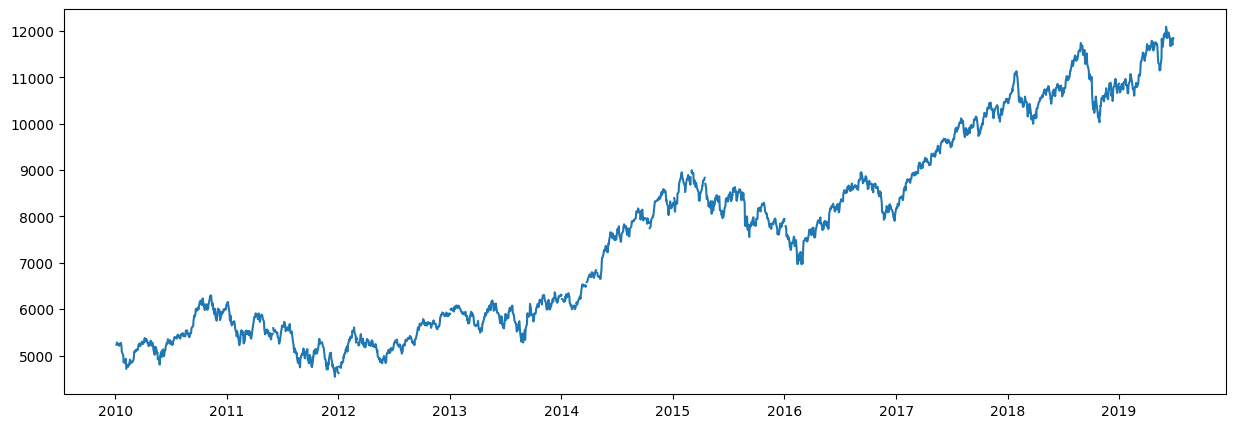

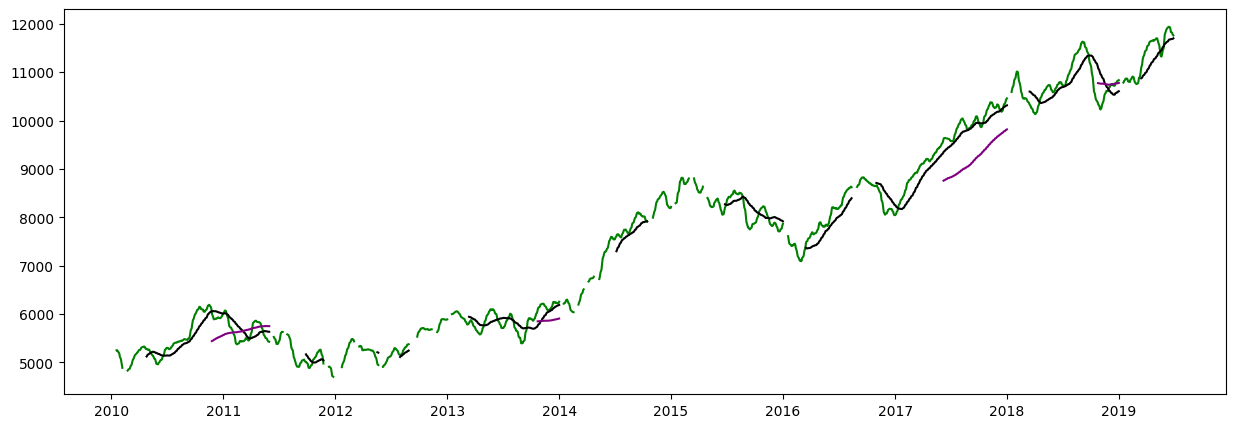

In [5]:
#preprocess data
history = dataset.loc[:,['Open','Close','Volume']]
history.index = pd.to_datetime(dataset['Date'])
history['Prev_Close'] = history.loc[:,'Close'].shift(1)
history['Prev_Open'] = history.loc[:,'Open'].shift(1)
history['10SMA'] = history['Prev_Close'].rolling(10).mean()
history['50SMA'] = history['Prev_Close'].rolling(50).mean()
history['200SMA'] = history['Prev_Close'].rolling(200).mean()
x = history.index.values
plt.figure(figsize = (15,5))
plt.plot(x, history['Prev_Close'])
plt.show()
#observing that as the size decreases it fits the data much better
plt.figure(figsize = (15,5))
plt.plot(x, history['10SMA'], color = "green")
plt.plot(x, history['50SMA'], color = "black")
plt.plot(x, history['200SMA'], color = "purple")
plt.show()

In [6]:
data = history['Close'].values
data = data.tolist()
print(data)

[5232.200195, 5277.899902, 5281.799805, 5263.100098, 5244.75, 5249.399902, 5210.399902, 5233.950195, 5259.899902, 5252.200195, 5274.850098, 5225.649902, 5221.700195, 5094.149902, 5036.0, 5007.899902, 4853.100098, 4867.25, 4882.049805, 4899.700195, 4830.100098, 4931.850098, 4845.350098, 4718.649902, nan, 4760.399902, 4792.649902, 4757.200195, 4826.850098, 4801.950195, 4855.75, 4914.0, 4887.75, 4844.899902, 4856.399902, 4870.049805, 4858.600098, 4859.75, 4922.299805, 5017.0, 5088.100098, 5080.25, 5088.700195, 5124.0, 5101.5, 5116.25, 5133.399902, 5137.0, 5128.899902, 5198.100098, 5231.899902, 5245.899902, 5262.799805, 5205.200195, 5225.299805, 5260.399902, 5282.0, 5302.850098, 5262.450195, 5249.100098, 5290.5, 5368.399902, 5366.0, 5374.649902, 5304.450195, 5361.75, 5339.700195, 5322.950195, 5273.600098, 5262.600098, 5203.649902, 5230.100098, 5244.899902, 5269.350098, 5304.100098, 5322.450195, 5308.350098, 5215.450195, 5254.149902, 5278.0, 5222.75, 5148.5, 5124.899902, 5090.850098, 5018.0

In [8]:
class DQN():
  def __init__(self, input_dim, is_eval = False, epsilon_decay_steps = 1000):
    self.state_dim = input_dim
    self.action_dim = 3 #sell, hold, buy
    self.is_eval = is_eval
    self.holdings = []
    self.memory = deque(maxlen=100)
    self.batch_size = 32
    self.gamma = 0.95 #Discount factor we use

    # greedy-epsilon policy
    self.epsilon = 1.0
    self.epsilon_min = 0.01
    self.epsilon_decay_val = (self.epsilon - self.epsilon_min)/epsilon_decay_steps
    self.build_model()
    self.loss()
    self.initialize_network()

  def build_model(self):
    self.inp = tf.placeholder(tf.float32, [None, self.state_dim], name = 'inputs')
    #print(self.inp)
    self.out = tf.placeholder(tf.float32, [None, self.action_dim], name = 'outputs')
    #self.inp = tf.reshape(self.inp , [-1, self.state_dim])
    #layers
    hid1 = tf.keras.layers.Dense(units = 60, activation = tf.nn.relu)(self.inp)
    hid2 = tf.keras.layers.Dense(units = 30, activation = tf.nn.relu)(hid1)
    hid3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(hid2)
    self.actions = tf.keras.layers.Dense(units = self.action_dim, activation = tf.nn.relu)(hid3)

    print('inputs:', self.inp)
    print('outputs:', self.out)
    print('actions:', self.actions)

  def loss(self):
    #we are using mean square loss in this network and optimizer = Adam
    self.loss = tf.reduce_mean(tf.square(self.out - self.actions))
    self.optimise = tf.train.AdamOptimizer(0.001).minimize(self.loss)

  def initialize_network(self):
    #initialising all the weights and biases to values which will get updated in the training function
    self.sess = tf.Session()
    self.sess.run(tf.global_variables_initializer())

  def action(self, state):
    if not self.is_eval and np.random.rand() <= self.epsilon:
      return random.randrange(self.action_dim)
    options = self.sess.run(self.actions, feed_dict = {self.inp : state})
    return np.argmax(options[0])

  def rl(self):
    loss_log = []
    mini_batch = [self.memory[i] for i in range(len(self.memory) - self.batch_size + 1, len(self.memory))]

    for action, state, reward, next_state, done in mini_batch:
      if not done:
        pred = self.sess.run(self.actions, feed_dict = {self.inp: next_state})
        target_s = reward + self.gamma*np.amax(pred[0])
      target_y = self.sess.run(self.actions, feed_dict = {self.inp: state})
      target_y[0][np.argmax(action)] = target_s
      feed_dict = {self.inp: state, self.out: target_y}
      loss = self.sess.run([self.loss, self.optimise], feed_dict = feed_dict)

      loss_log.append(loss)

      # reduce the value of epsilon
      if self.epsilon > self.epsilon_end:
          self.epsilon -= self.epsilon_decay_val

      return loss_log



In [9]:
input_size = 100
agent = DQN(input_size)

inputs: Tensor("inputs:0", shape=(?, 100), dtype=float32)
outputs: Tensor("outputs:0", shape=(?, 3), dtype=float32)
actions: Tensor("dense_3/Relu:0", shape=(?, 3), dtype=float32)


In [ ]:
#now we train the network

#global variables
iteration = 10
input_size = 100
LOG = False
data = stock_close_prices(history)
for i in range(iteration):
  loss_net = []
  profits_net = []
  state = generate_price_state(data, 0, input_size+1)
  temp = tf.convert_to_tensor(state)
  current_state = tf.reshape(temp,  [-1, input_size])
  print(current_state)
  profit = 0.0
  agent.inventory = []
  total_loss = []
  mean_loss = []

  for k in range(len(data)):
    action = agent.action(current_state)
    next_state = generate_price_state(data, k + 1, input_size + 1)
    reward = 0
    if action == 2:
      #buy
      agent.inventory.append(data[k])
      if LOG:
        print('Buy:', data[k])
    elif action == 0 and len(agent.inventory) > 0:
      price = agent.inventory.pop(0)
      p = data[k] - price
      reward = max(data[k] - price, 0)
      profit += p
      if LOG:
        print("Sell: ", data[k], " | Profit: ", p)

    done = (k == len(data) - 1)
    agent.memory.append((current_state , action, reward, next_state, done))
    temp_ = tf.convert_to_tensor(next_state)
    current_state = tf.reshape(next_state,  [-1, input_size])
    if done and LOG:
      print("Total Profit: ", profit)
    if len(agent.memory) > agent.batch_size:
      losses = agent.rl()
      total_loss.append(np.sum(losses))
      mean_loss.append(np.mean(losses))
  loss_net.append(np.mean(mean_loss))
  profits_net.append(profit)

  print('iter: {0}, loss: {1}, profits: {2}'.format(i, loss_net[-1], profits_net[-1]))





Tensor("Reshape_285:0", shape=(1, 100), dtype=float64)


ValueError: ignored